In [ ]:
# Imports & basic configuration (with Kaggle download integration)
import os, random, zipfile, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Adjustable hyperparameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
INITIAL_LR = 1e-3
EPOCHS = 15
MODEL_NAME = "intel_scene_cnn.h5"

# Attempt Kaggle dataset download using kagglehub
DATA_ROOT = None
try:
    try:
        import kagglehub
    except ImportError:
        import sys, subprocess
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kagglehub'])
        import kagglehub
    ds_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    extract_root = os.path.join(ds_path, 'extracted')
    os.makedirs(extract_root, exist_ok=True)
    # Extract any zip files present under the dataset path
    for fname in os.listdir(ds_path):
        if fname.lower().endswith('.zip'):
            zf = os.path.join(ds_path, fname)
            try:
                with zipfile.ZipFile(zf, 'r') as z:
                    z.extractall(extract_root)
            except zipfile.BadZipFile:
                pass

    # Function to detect a directory that directly contains seg_train and seg_test
    def detect_root(start_dirs):
        for base in start_dirs:
            if not os.path.isdir(base):
                continue
            for root, dirs, files in os.walk(base):
                if ('seg_train' in dirs) and ('seg_test' in dirs):
                    return root
        return None

    candidate = detect_root([extract_root, ds_path])
    if candidate is not None:
        DATA_ROOT = candidate
        print('Dataset downloaded to:', ds_path)
        print('Detected DATA_ROOT =', DATA_ROOT)
    else:
        print('Could not auto-detect seg_train/seg_test after extraction/download.')
except Exception as e:
    print('Kaggle download failed:', e)

# Fallback manual path if download not available
if DATA_ROOT is None:
    DATA_ROOT = 'intel-data'  # user-provided/manual extraction path
    if not os.path.isdir(DATA_ROOT):
        print('Please ensure dataset zip files are extracted so seg_train/seg_test/seg_pred exist under', DATA_ROOT)

# Class indices mapping expected
CLASS_MAP = {'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
print('Class map:', CLASS_MAP)
print('TensorFlow version:', tf.__version__)
print('Using DATA_ROOT =', DATA_ROOT)


In [2]:
# Data generators with augmentation for training
train_dir = os.path.join(DATA_ROOT, 'seg_train', 'seg_train') if os.path.isdir(os.path.join(DATA_ROOT, 'seg_train', 'seg_train')) else os.path.join(DATA_ROOT, 'seg_train')
val_split = 0.15

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=val_split
)

test_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test directory may be nested similarly
test_dir = os.path.join(DATA_ROOT, 'seg_test', 'seg_test') if os.path.isdir(os.path.join(DATA_ROOT, 'seg_test', 'seg_test')) else os.path.join(DATA_ROOT, 'seg_test')

test_flow = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Classes in generator:", train_gen.class_indices)


Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes in generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


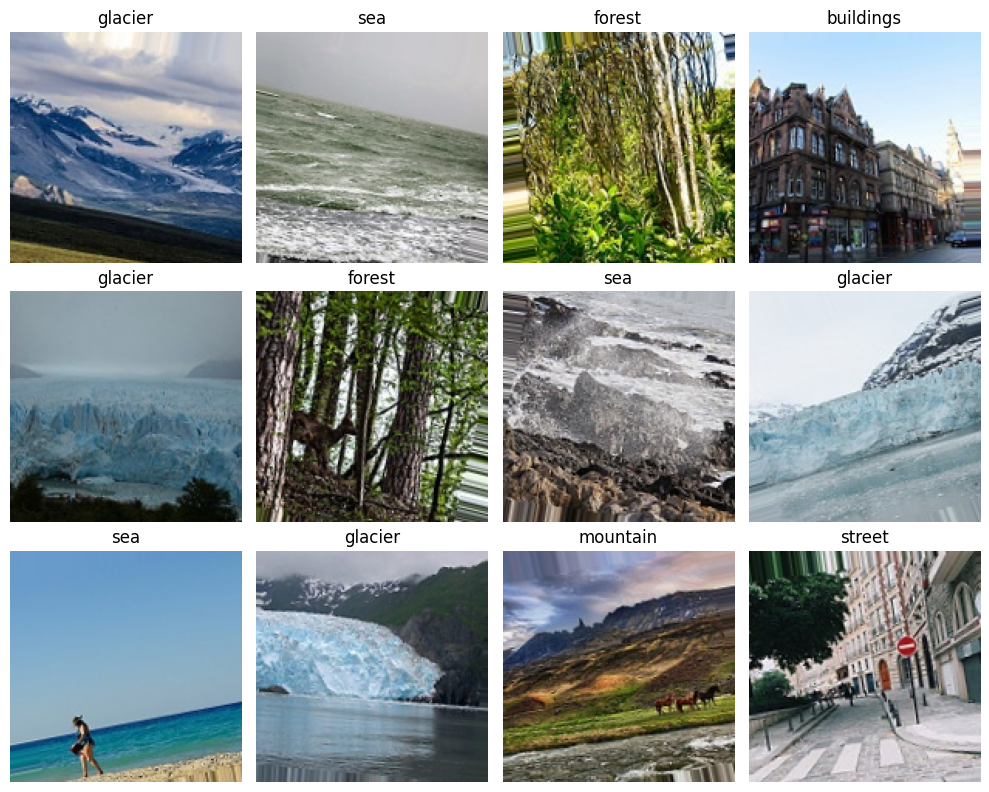

In [3]:
# Visualize a few samples
batch_imgs, batch_labels = next(train_gen)
labels_inv = {v:k for k,v in train_gen.class_indices.items()}
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(batch_imgs[i])
    plt.title(labels_inv[np.argmax(batch_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# CNN Model Architecture: 4 conv blocks with varied kernels, pooling, BN, and dropout
inputs = keras.Input(shape=(*IMG_SIZE, 3))

# Block 1: 5x5 kernel, MaxPooling (experimenting with larger kernel)
x = layers.Conv2D(32, (5,5), padding='same', activation=None)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.2)(x)

# Block 2: 3x3 kernel, AveragePooling (experimenting with different pooling strategy)
x = layers.Conv2D(64, (3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.3)(x)

# Block 3: 3x3 kernel, MaxPooling
x = layers.Conv2D(128, (3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.4)(x)

# Block 4: 3x3 kernel, MaxPooling (deeper network for better feature extraction)
x = layers.Conv2D(256, (3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Flatten and dense layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 37, 37, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,702,086 (21.75 MB)

 Trainable params: 5,701,126 (21.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compile & train
opt = keras.optimizers.Adam(learning_rate=INITIAL_LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1,
    callbacks=callbacks
)

model.save(MODEL_NAME)
# print("Model saved as", MODEL_NAME)


94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 494ms/step - accuracy: 0.6047 - loss: 0.9633
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 494ms/step - accuracy: 0.6047 - loss: 0.9633
Test accuracy: 60.47 %
Test loss: 0.9632719159126282
Test accuracy: 60.47 %
Test loss: 0.9632719159126282


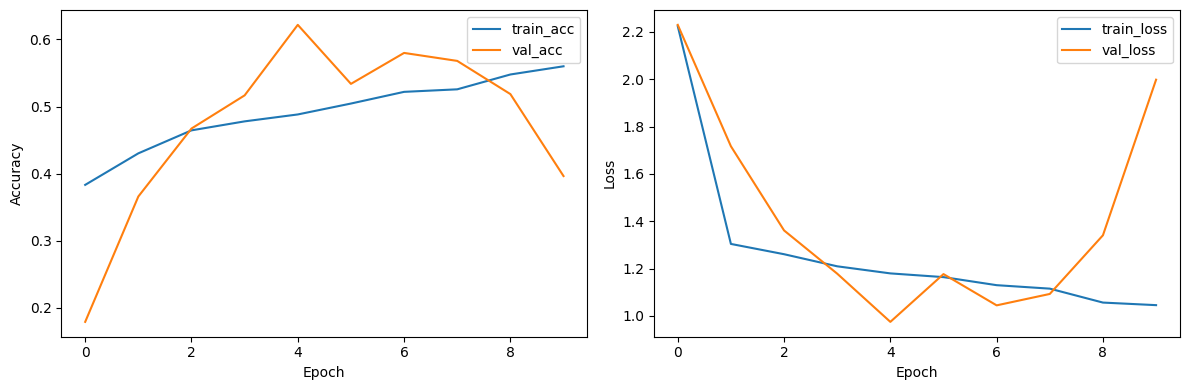

94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step


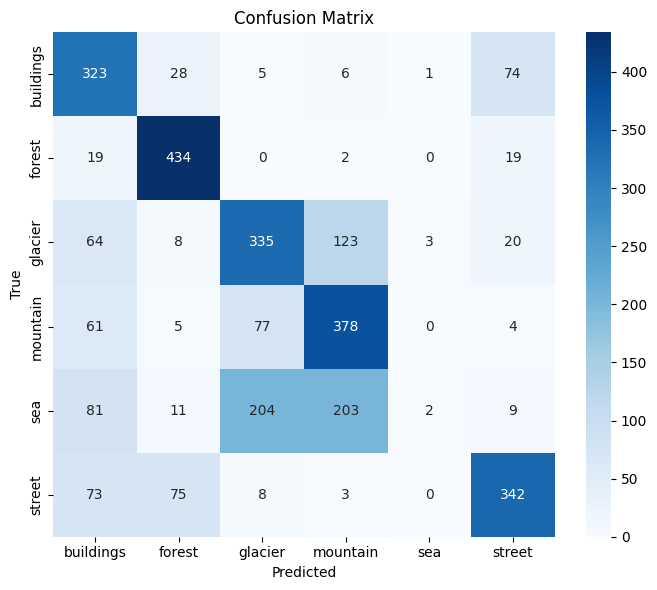

              precision    recall  f1-score   support

   buildings       0.52      0.74      0.61       437
      forest       0.77      0.92      0.84       474
     glacier       0.53      0.61      0.57       553
    mountain       0.53      0.72      0.61       525
         sea       0.33      0.00      0.01       510
      street       0.73      0.68      0.71       501

    accuracy                           0.60      3000
   macro avg       0.57      0.61      0.56      3000
weighted avg       0.57      0.60      0.55      3000



In [ ]:
# Evaluation on test set
test_loss, test_acc = model.evaluate(test_flow, verbose=1)
print("Test accuracy:", round(test_acc*100, 2), "%")
print("Test loss:", test_loss)

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
y_true = test_flow.classes
probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(probs, axis=1)
idx_to_class = {v:k for k,v in test_flow.class_indices.items()}
labels_order = [idx_to_class[i] for i in range(len(idx_to_class))]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=labels_order))
